In [10]:
from IPython.display import display
import tqdm
import random
from matplotlib import pyplot as plt

import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.models as models

import wandb
wandb.login()
wandb_proj = 'fgvca_aircraft'

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [3]:
height, width = 224, 224
ts = transforms.Compose([transforms.Resize((height, width)), transforms.ToTensor()])
fgvca = datasets.FGVCAircraft(root='data', download=True, transform=ts)
classes = fgvca.classes

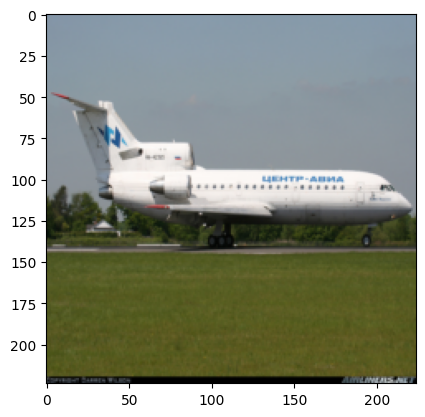

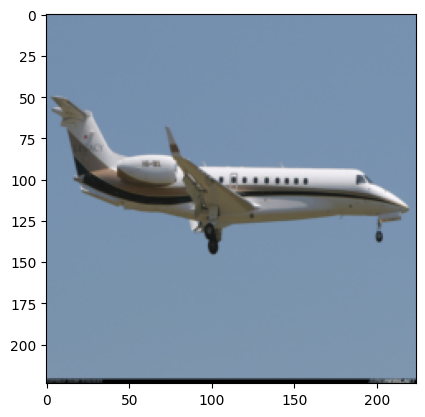

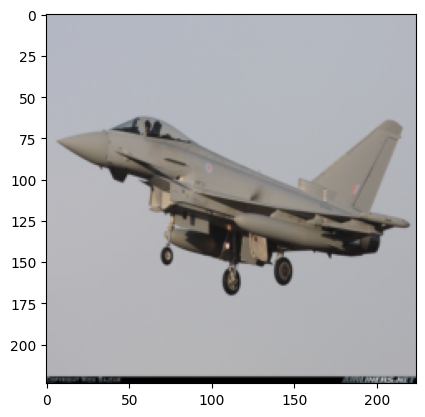

In [4]:
n_samples = 3

for _ in range(n_samples):
    idx = random.randint(0, len(fgvca))
    img, label_idx =  fgvca[idx]
    img = img.permute(1, 2, 0)
    plt.imshow(img.numpy())
    plt.show()

## Feed forward neural network

In [5]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(50176, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = self.pool3(out)
        out = self.relu3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        return out

In [6]:
# https://www.folio3.ai/blog/best-cnn-architecture-for-image-processing/
# https://github.com/Aleadinglight/Pytorch-VGG-19/blob/master/VGG_19.ipynb

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.adpt_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_size)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = self.adpt_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X, y
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    return correct

In [8]:
# Define the dataset and transformation
dataset = fgvca

# Define the sizes of the training and testing subsets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing subsets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define the batch size for the data loader
batch_size = 50

# Create the data loaders for the training and testing subsets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the model hyperparameters
lr = 0.001
epochs = 10
input_size = height * width
output_size = len(classes)

run_config = {
    'height': height,
    'width': width,
    'learning_rate': lr,
    'epochs': epochs,
    'batch_size': batch_size,
    'architecture': 'Resnet18',
    'optimizer': 'Adam'
}

# Create the CNN model instance
#model = CNN()
model = models.resnet18(pretrained=False)

# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Log model to wandb 
wandb.init(
    project=wandb_proj,
    config=run_config,
)


# Train the model
num_batches = len(train_loader) // batch_size
for epoch in range(epochs):
    correct = 0
    acc = 0
    epoch_loss = 0
    for inputs, labels in tqdm.tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs.view(-1, 3, height, width))
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (torch.max(outputs, dim=1).indices == labels).sum().item()
        epoch_loss += loss.item()

    # Print the training progress
    acc = correct / len(fgvca)
    loss = epoch_loss / num_batches
    wandb.log({"acc": acc, "loss": loss})
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {acc:.2f}')

# Testing
print('Train accuracy:')
train_acc = test(train_loader, model, criterion)

wandb.log({'Train Accuracy': train_acc})

print('Test accuracy:')
test_acc = test(test_loader, model, criterion)

wandb.log({'Test Accuracy': test_acc})

wandb.finish()


C:\Users\Jonatan\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jonatan\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


acc,▁█
loss,█▁
acc,0.00765
loss,246.43058


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [16:57<00:00,  9.51s/it]


Epoch 1/10, Loss: 252.2611, Accuracy: 0.02


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [16:41<00:00,  9.36s/it]


Epoch 2/10, Loss: 224.9449, Accuracy: 0.04


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [16:50<00:00,  9.44s/it]


Epoch 3/10, Loss: 202.0941, Accuracy: 0.08


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [17:49<00:00, 10.00s/it]


Epoch 4/10, Loss: 178.8431, Accuracy: 0.12


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [17:14<00:00,  9.67s/it]


Epoch 5/10, Loss: 157.3899, Accuracy: 0.16


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [17:40<00:00,  9.91s/it]


Epoch 6/10, Loss: 139.7091, Accuracy: 0.22


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [18:50<00:00, 10.57s/it]


Epoch 7/10, Loss: 124.0203, Accuracy: 0.27


 81%|█████████████████████████████████████████████████████████████████▊               | 87/107 [15:35<04:12, 12.61s/it]